In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/experiments/data"
X, y = get_data("sdpa_backward", base_dir, sample_rate=1.0)
X.info()

0it [00:00, ?it/s]

24it [00:32,  1.35s/it]
100%|██████████| 4/4 [00:05<00:00,  1.50s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464256 entries, 0 to 464255
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   b                  464256 non-null  int64  
 1   h                  464256 non-null  int64  
 2   s_q                464256 non-null  int64  
 3   s_kv               464256 non-null  int64  
 4   d_qk               464256 non-null  int64  
 5   d_v                464256 non-null  int64  
 6   gflops             464256 non-null  float64
 7   dtype_16           464256 non-null  bool   
 8   dtype_32           464256 non-null  bool   
 9   dtype_b16          464256 non-null  bool   
 10  backend_cudnn      464256 non-null  bool   
 11  backend_efficient  464256 non-null  bool   
 12  backend_flash      464256 non-null  bool   
 13  is_causal_0        464256 non-null  bool   
 14  is_causal_1        464256 non-null  bool   
dtypes: bool(8), float64(1), int64(6)
memory usage: 28.3

In [3]:
df = pd.concat([X, y], axis=1)
df = df.dropna()
df = df[df["time"] > 0]
X, y = df.drop(columns=["time"]), df["time"]

# Initial Fitting

## Decision Tree

Train--------
Mean Squared Error: 12.345207947235778
MAPE: 0.014224426066155555
R-squared: 0.9986913821995578


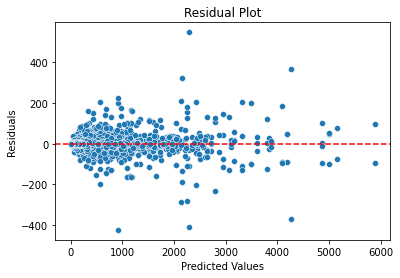

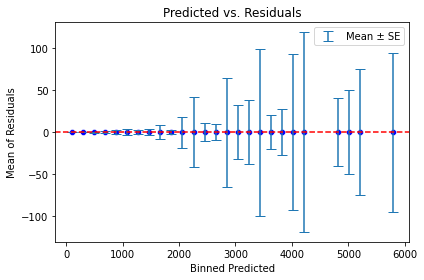

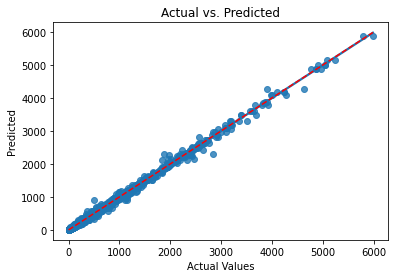

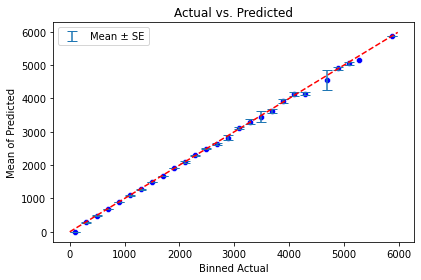

Val--------
Mean Squared Error: 67.00808072372158
MAPE: 0.03159734693917134
R-squared: 0.9930342649369657


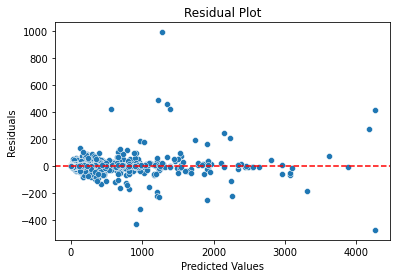

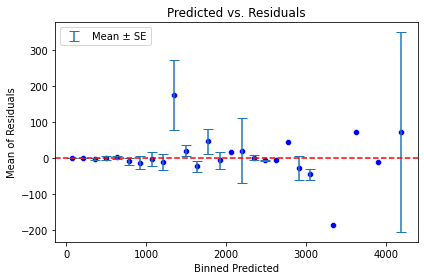

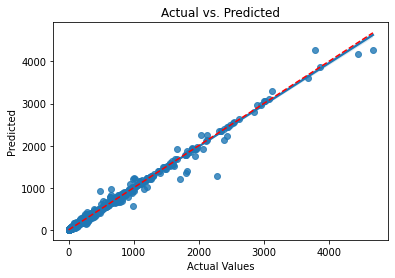

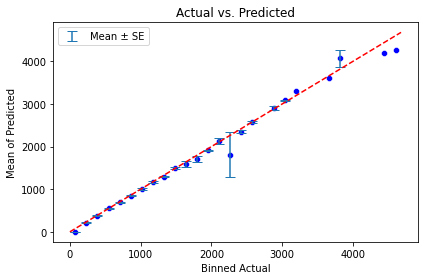

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

In [17]:
get_feature_importance(X.columns, tree_model)

,Feature,Importance
6,gflops,0.656272
11,backend_efficient,0.104779
8,dtype_32,0.089405
13,is_causal_0,0.055140
14,is_causal_1,0.029938
2,s_q,0.019227
3,s_kv,0.016116
4,d_qk,0.013820
5,d_v,0.011913
0,b,0.001711


### Errors by category

Train--------
Mean Squared Error: 23.50874975777043
MAPE: 0.014896851869450143
R-squared: 0.9975518377074167


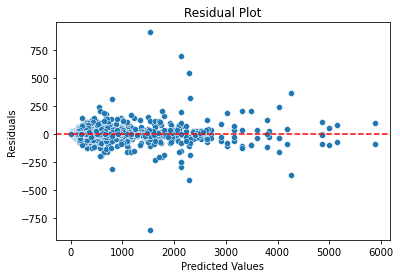

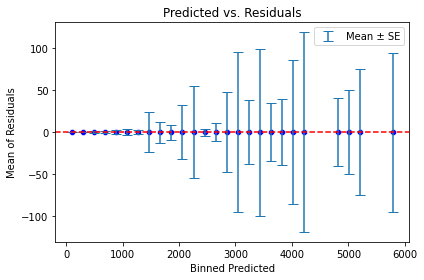

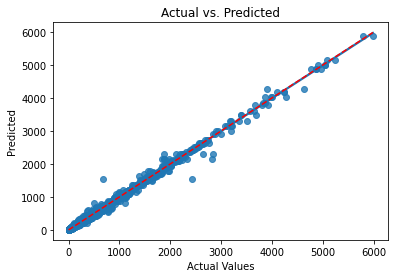

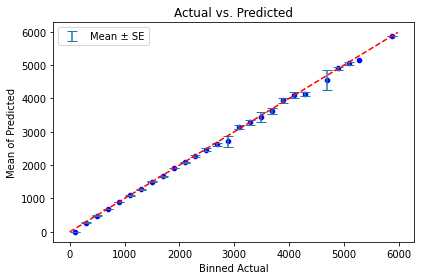

Val--------
Mean Squared Error: 104.34502363021632
MAPE: 0.0376123438689902
R-squared: 0.9879312474355378


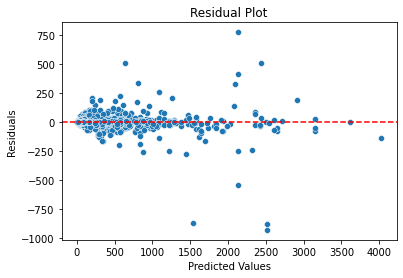

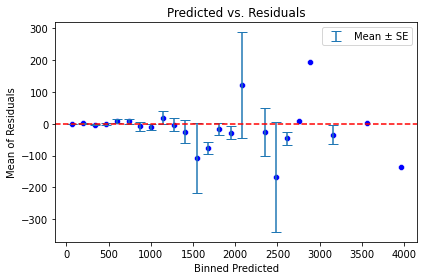

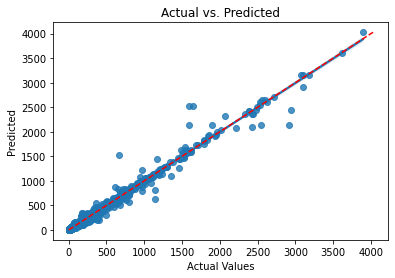

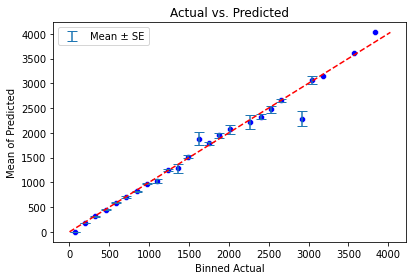

In [29]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)

tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)

run_val_pipeline(tree_model, X_train, X_val, y_train, y_val, bins=30)

In [34]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train["time_pred"] = tree_model.predict(X_train)
df_val = pd.concat([X_val, y_val], axis=1)
df_val["time_pred"] = tree_model.predict(X_val)

for dtype in ["16", "32", "b16"]:
    df_train_dtype = df_train.query(f"dtype_{dtype}")
    df_val_dtype = df_val.query(f"dtype_{dtype}")
    
    print(mean_squared_error(df_train_dtype["time"], df_train_dtype["time_pred"]), mean_squared_error(df_val_dtype["time"], df_val_dtype["time_pred"]))

13.562387096816428 45.23647605445894
86.2358123181612 237.16063163696862
5.688114743695963 105.05150132509245


## Forest

### Fit directly

Train--------
Mean Squared Error: 20.120336414034778
MAPE: 0.016380498245211227
R-squared: 0.9979223813578886


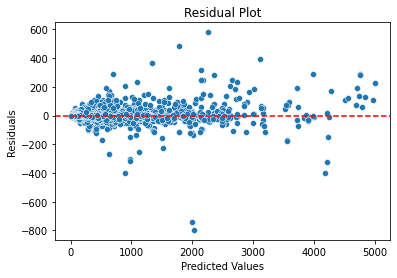

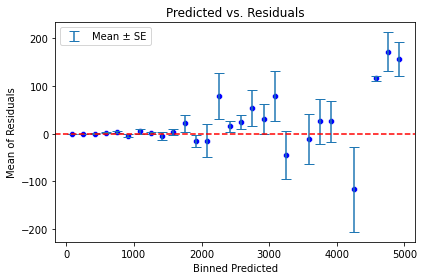

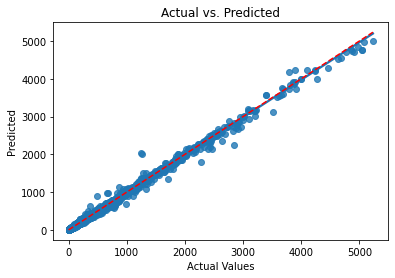

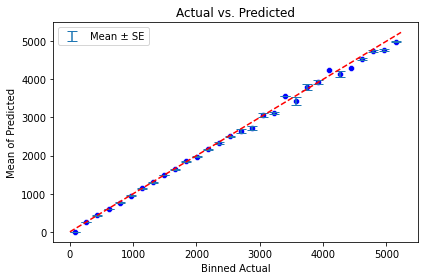

Val--------
Mean Squared Error: 80.89308205077069
MAPE: 0.030019074733350835
R-squared: 0.9901346003358065


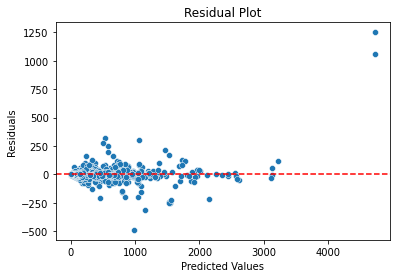

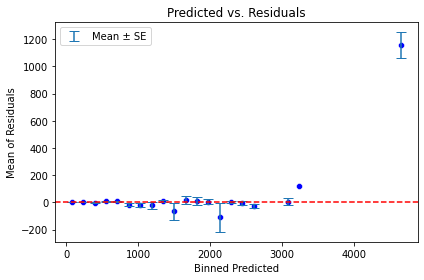

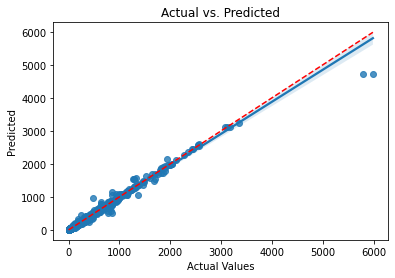

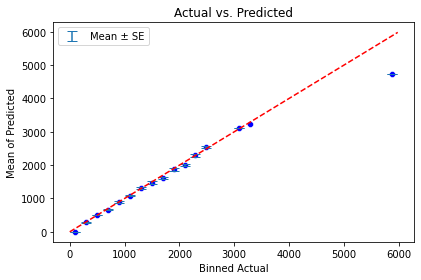

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = RandomForestRegressor(max_depth=60, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

### Errors by category

Train--------
Mean Squared Error: 29.160748106861686
MAPE: 0.018715204636518056
R-squared: 0.9968604014356461


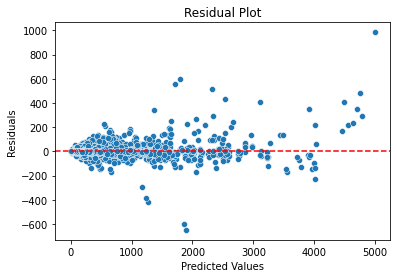

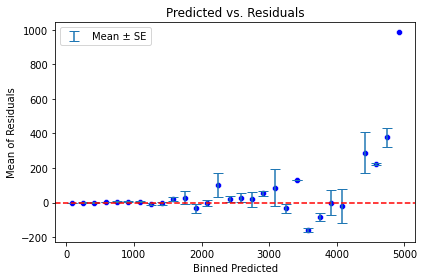

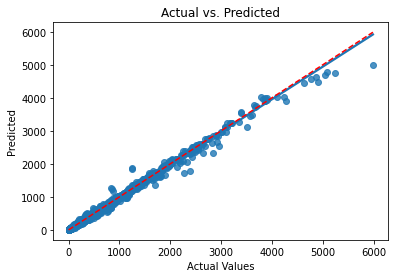

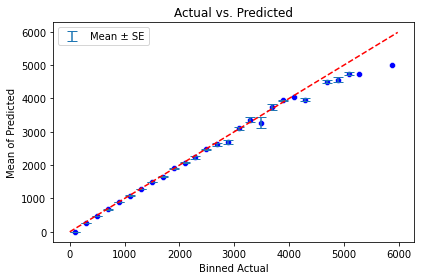

Val--------
Mean Squared Error: 76.01693556365575
MAPE: 0.034572137919247764
R-squared: 0.9924148368170105


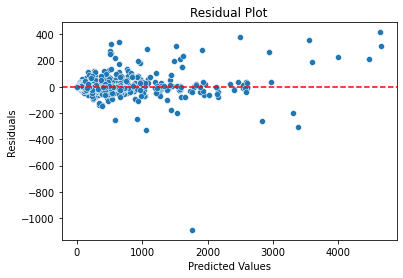

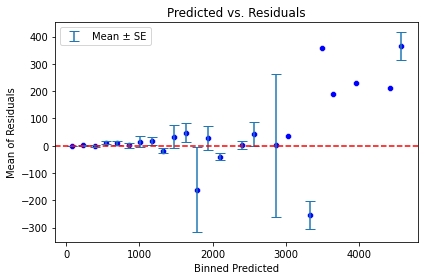

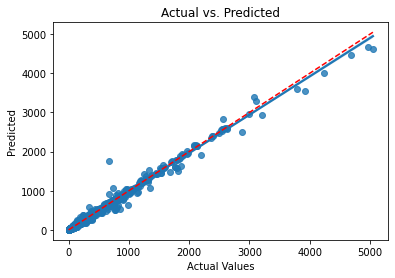

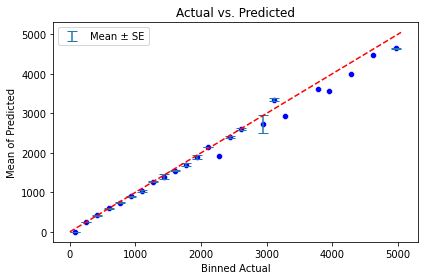

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)

tree_model = RandomForestRegressor(max_depth=80, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)

run_val_pipeline(tree_model, X_train, X_val, y_train, y_val, bins=30)

In [6]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train["time_pred"] = tree_model.predict(X_train)
df_val = pd.concat([X_val, y_val], axis=1)
df_val["time_pred"] = tree_model.predict(X_val)

for dtype in ["16", "32", "b16"]:
    df_train_dtype = df_train.query(f"dtype_{dtype}")
    df_val_dtype = df_val.query(f"dtype_{dtype}")
    
    print(dtype, mean_squared_error(df_train_dtype["time"], df_train_dtype["time_pred"]), mean_squared_error(df_val_dtype["time"], df_val_dtype["time_pred"]))
    print(dtype, mean_absolute_percentage_error(df_train_dtype["time"], df_train_dtype["time_pred"]), mean_absolute_percentage_error(df_val_dtype["time"], df_val_dtype["time_pred"]))

16 14.279495919763592 68.16309120498269
16 0.01647809517189764 0.030307521641992515
32 95.28143822964672 214.48849379650406
32 0.029293373155576948 0.05545183520592597
b16 14.765649787660747 23.138548884722482
b16 0.016268836115203255 0.02967014166999922


# Per dtype and backend

## dtype32

Train--------
Mean Squared Error: 60.397510755503326
MAPE: 0.026168325164367172
R-squared: 0.9977978106339053


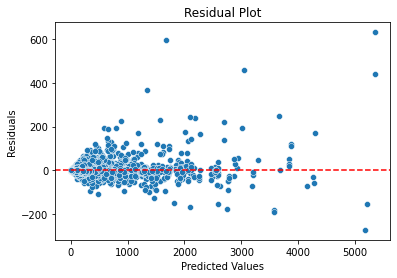

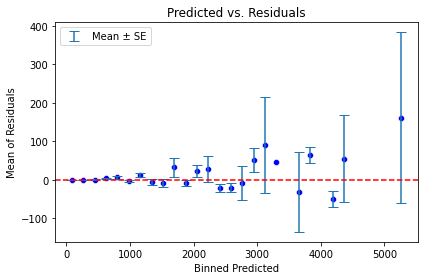

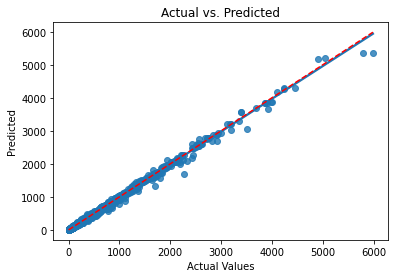

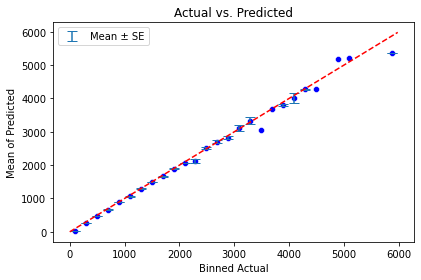

Val--------
Mean Squared Error: 193.78869546380568
MAPE: 0.04923535511196801
R-squared: 0.9931548282250341


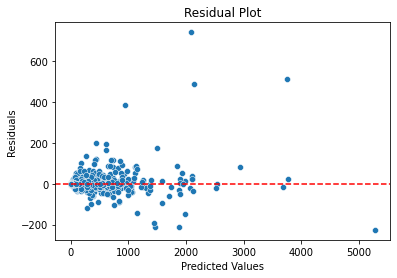

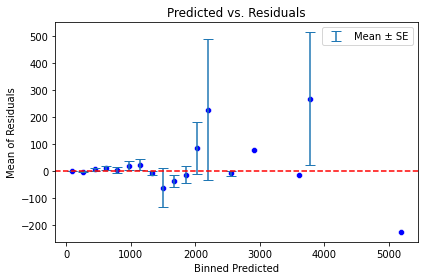

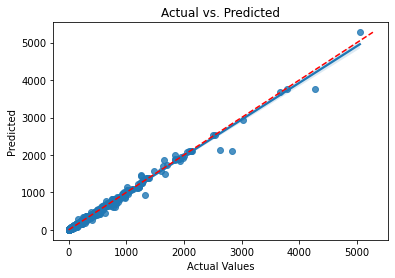

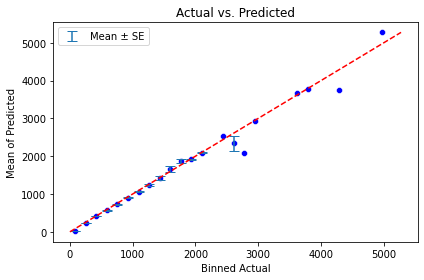

In [40]:
df_dtype = df.query("dtype_32")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = RandomForestRegressor(max_depth=80, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

## dtype16

### Combined

Train--------
Mean Squared Error: 37.07314041644246
MAPE: 0.019812937433380667
R-squared: 0.9924920000287542


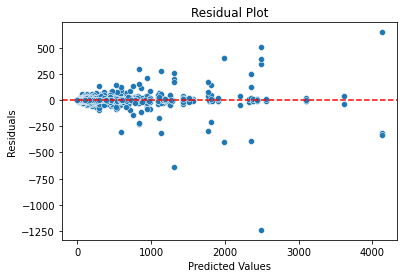

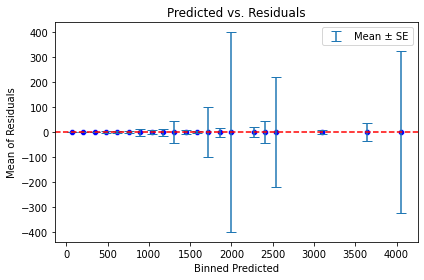

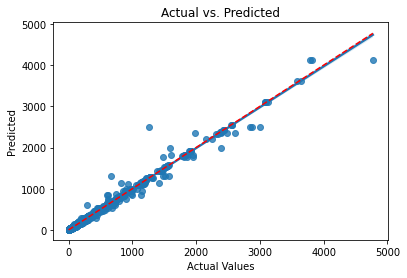

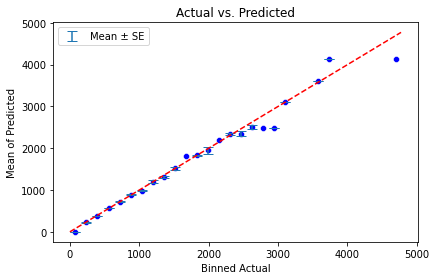

Val--------
Mean Squared Error: 210.6496631340605
MAPE: 0.0487044738575321
R-squared: 0.9701859380994156


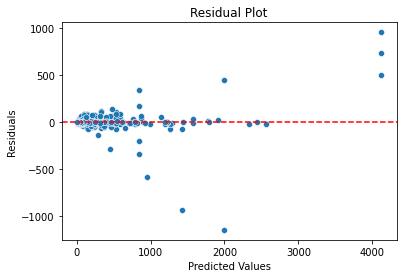

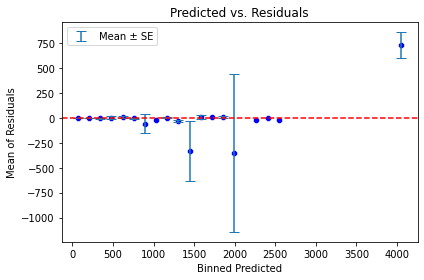

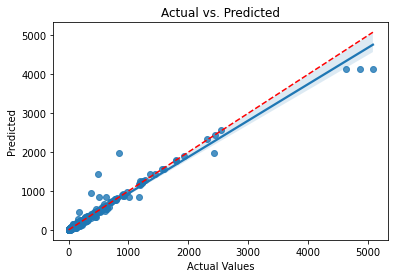

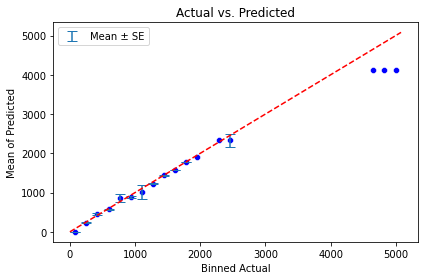

In [7]:
df_dtype = df.query("dtype_16")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

### cudnn

Train--------
Mean Squared Error: 0.23266930516657403
MAPE: 0.016339496350451566
R-squared: 0.9974979719201064


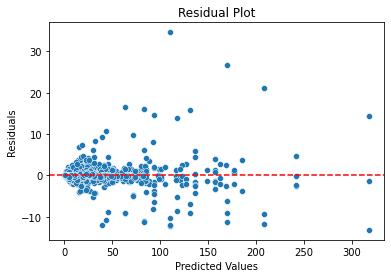

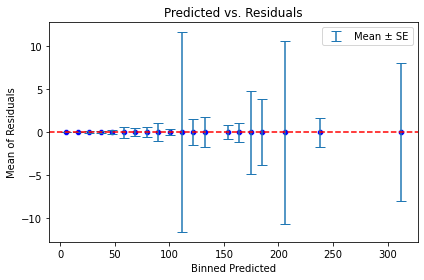

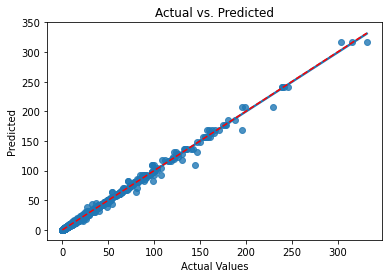

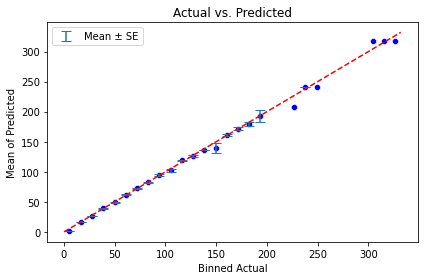

Val--------
Mean Squared Error: 1.7839077059953357
MAPE: 0.03856924303740289
R-squared: 0.9860681641289224


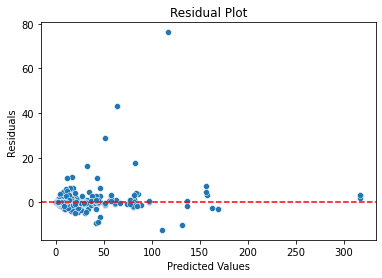

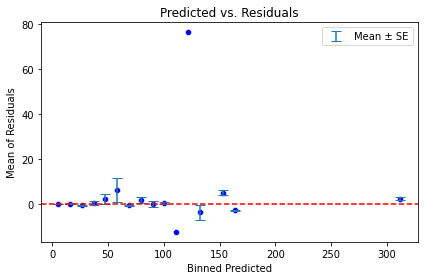

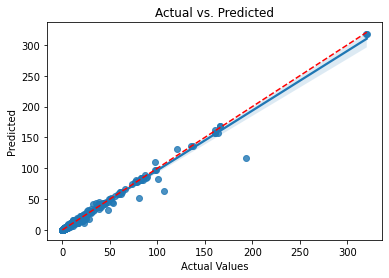

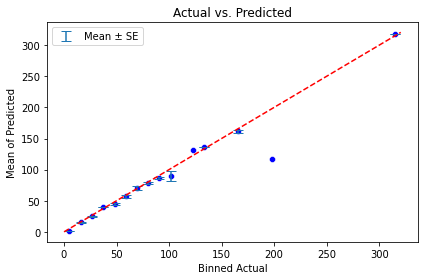

In [8]:
df_dtype = df.query("dtype_16 and backend_cudnn")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

### efficient

Train--------
Mean Squared Error: 99.9285100335885
MAPE: 0.026369806237402493
R-squared: 0.991388375934912


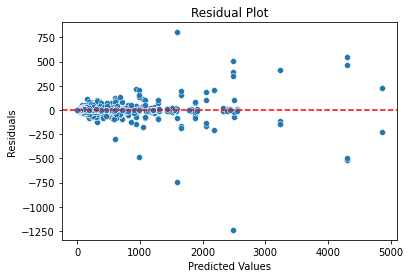

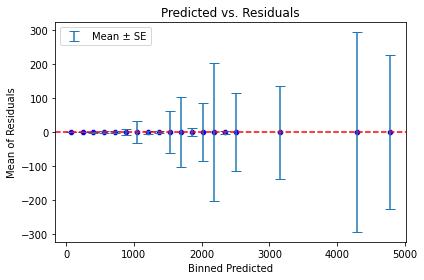

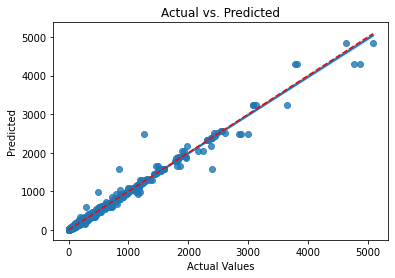

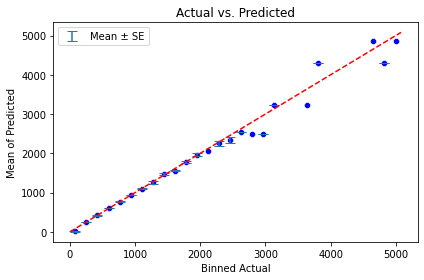

Val--------
Mean Squared Error: 226.16702819879322
MAPE: 0.0654173765187239
R-squared: 0.9785710093547916


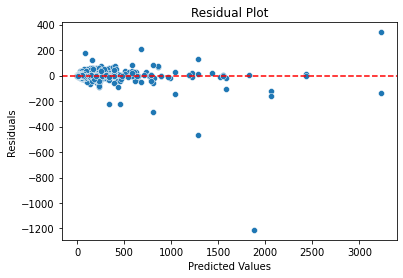

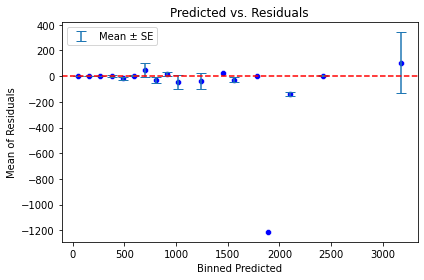

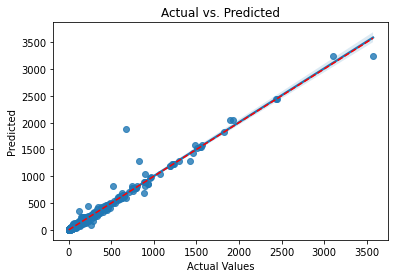

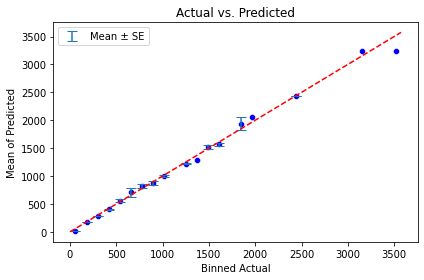

In [10]:
df_dtype = df.query("dtype_16 and backend_efficient")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

### flash

Train--------
Mean Squared Error: 0.6838455555730554
MAPE: 0.014533990021004764
R-squared: 0.9979769398922413


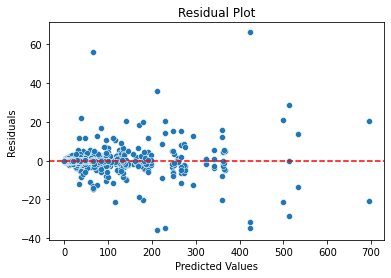

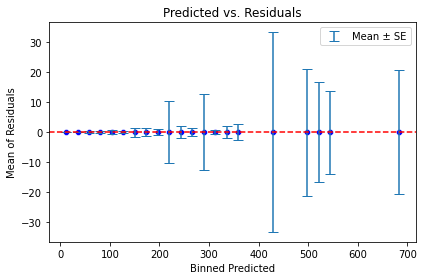

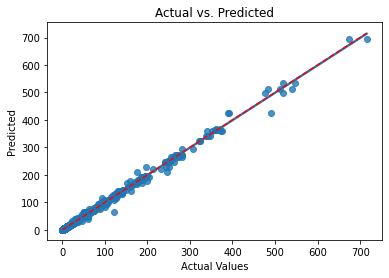

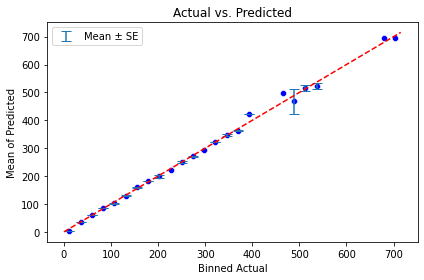

Val--------
Mean Squared Error: 6.122717816378915
MAPE: 0.034194416474239514
R-squared: 0.9822791586870677


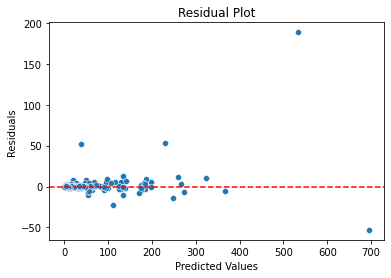

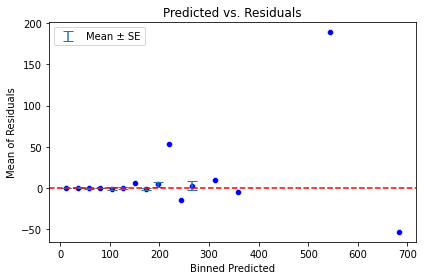

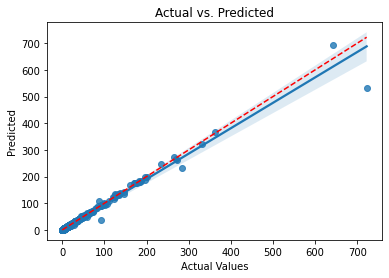

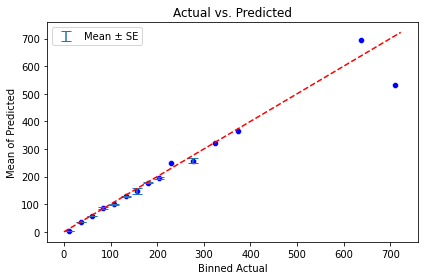

In [9]:
df_dtype = df.query("dtype_16 and backend_flash")
X_dtype, y_dtype = df_dtype.drop(columns=["time"]), df_dtype["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_dtype, y_dtype, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = DecisionTreeRegressor(max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)

## b16

Train--------
Mean Squared Error: 30.33330173033326
MAPE: 0.022788458794985974
R-squared: 0.9947052632202543


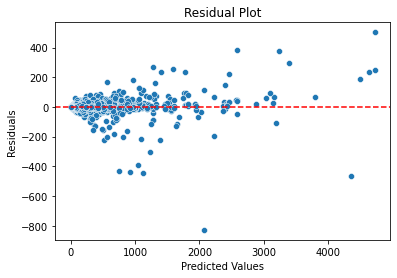

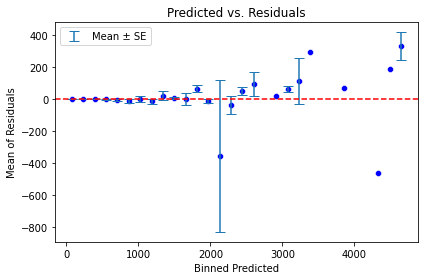

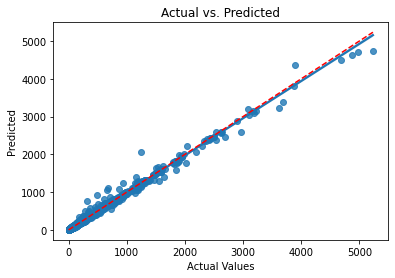

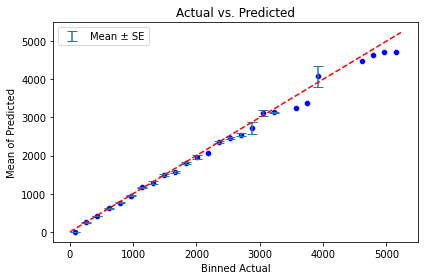

Val--------
Mean Squared Error: 61.54642956164327
MAPE: 0.04107959583309054
R-squared: 0.9833101639395366


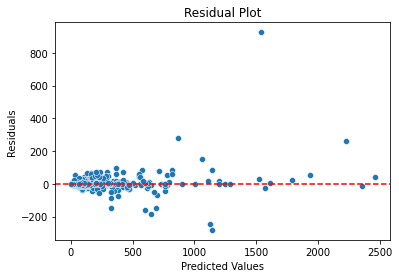

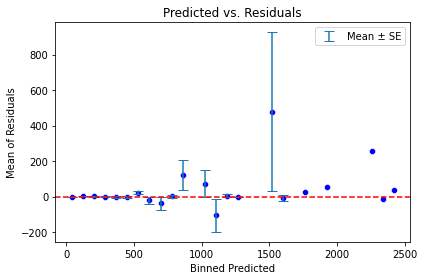

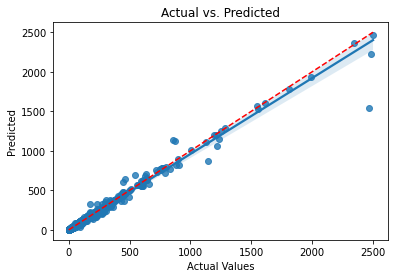

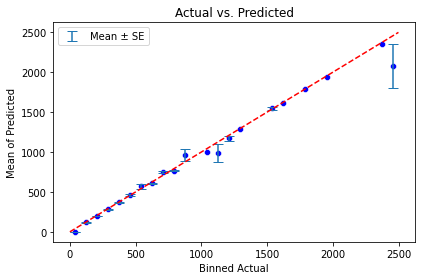

In [39]:
df_32 = df.query("dtype_b16")
X_32, y_32 = df_32.drop(columns=["time"]), df_32["time"]

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X_32, y_32, return_concat=False)
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

tree_model = RandomForestRegressor(max_depth=80, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_cv, y_cv)

run_val_pipeline(tree_model, X_cv, X_test, y_cv, y_test, bins=30)